# How to handle background images in plot2d

Functions are defined in /scripts/python3/postel/plot2d.py

## Change the mesh coordonate system and plot background image

In this example, the package pyproj is used to change the coordonate system of the mesh.

To install this package with conda, run one of the following:

    conda install -c conda-forge pyproj
    conda install -c conda-forge/label/gcc7 pyproj
    conda install -c conda-forge/label/broken pyproj
    conda install -c conda-forge/label/cf201901 pyproj

For more information, refer to: https://pyproj4.github.io/pyproj/html/installation.html

In [1]:
from os import environ, path
import sys
import numpy as np
try:
    import pyproj
except ImportError:
    raise Exception("Warning: pyproj is mandatory to run this notebook")
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from data_manip.extraction.telemac_file import TelemacFile
from postel.plot2d import *

# File we are going to use
file_name = path.join(environ['HOMETEL'], 
                      'examples', 
                      'telemac2d', 
                      'tide',
                      'f2d_tide-jmj_type.slf')

# Initalisaing Telemac file reader
res = TelemacFile(file_name)

# Getting values
H = res.get_data_value('WATER DEPTH', 0)
Ux = res.get_data_value('VELOCITY U', 0)
Uy = res.get_data_value('VELOCITY V', 0)

### Change the coordonate system of the mesh 

EPSG codes are used to define the coordonate system, to identify these codes, one can use:
https://georezo.net/wiki/main/dico/epsg

Here are some examples of EPSG codes:

    EPSG:4326: WGS84
    EPSG:2154: RGF93 / Lambert-93
    EPSG:27561: NTF (Paris) / Lambert Nord France
    EPSG:27562: NTF (Paris) / Lambert Centre France
    EPSG:27563: NTF (Paris) / Lambert Sud France
    
To change coordonate system of the mesh x and y arrays, simply call "pyproj.transform" method with wanted projections as follows:

In [2]:
# In this case we want to change coordonates from Lambert Nord to WGS84:
wgs84 = pyproj.Proj("+init=EPSG:4326")
lamb1 = pyproj.Proj("+init=EPSG:27561")

res.tri.x, res.tri.y = pyproj.transform(lamb1, wgs84, res.tri.x, res.tri.y)

/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is depreca

### Plot background image

To plot background image, call the "plot2d_image" function with the location of the image ("image_file").

The position of the image on the canvas is provided with the "extent" argument which contains the bottom left corner and top right corner coordonates of the image. Note that it is not possible to rotate the image at the moment.

The distorsion of the image is adjusted via the "aspect" argument. By default the aspect ratio in matplotlib is set to 1. We can adjust this setting to mimic the mercator projection i.e. for a latitude of 48.897 DD, the mercator projection gives us a 1.521 aspect ratio.

However, one should notice that the function can only manage constant aspect ratio. Or for mercator projection, aspect varies with latitude. As a consequence, constant aspect ratio background images might not look good for very large models. For complex projections, see: https://matplotlib.org/basemap/users/examples.html.

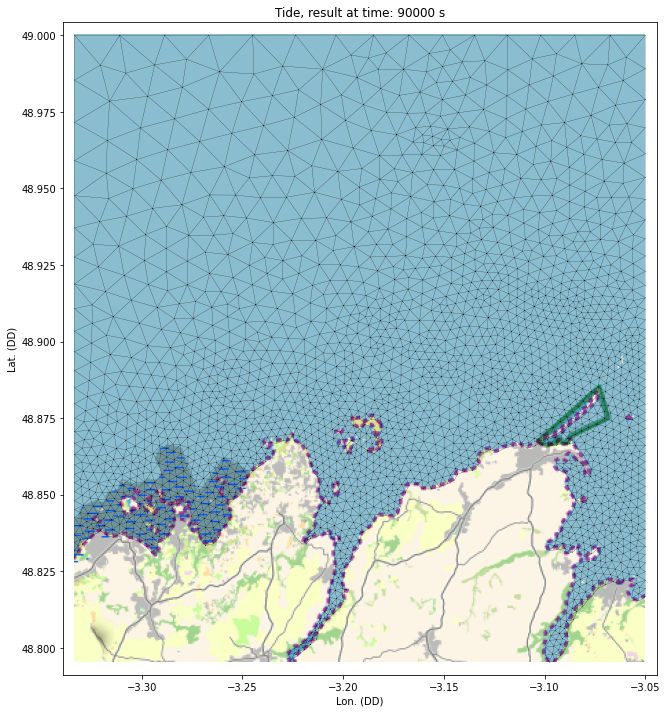

In [3]:
# Initialising matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

# Plotting mesh 
plot2d_triangle_mesh(ax, res.tri, color='k', linewidth=0.2)

# Defining canvas limits
xlim = [np.min(res.tri.x), np.max(res.tri.x)]
ylim = [np.min(res.tri.y), np.max(res.tri.y)]

# Plot background image:
img_file = path.join(environ['HOMETEL'], 'notebooks', 'data', 'background_map.png')
plot2d_image(ax, image_file=img_file, 
             extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
             aspect=1.52, alpha=1.)

# Defining labels
ax.set_title('Tide, result at time: %d s'%res.times[0])
ax.set_xlabel('Lon. (DD)')
ax.set_ylabel('Lat. (DD)')

# Showing the plot
plt.show()

## Adding plot2d layers on top of background image

All plot2d functions are compatible with each other, including the "plot2d_image".
In other words, layers can be piled up.

But in order to visualise results properly, opacity of the layers may need to be adjusted with the "alpha" argument.
All plot2d functions can take an "alpha" between 0 (maximum opacity) and 1 (no opacity) as argument.

In the following, two examples of complex 2d plots with background image are given:

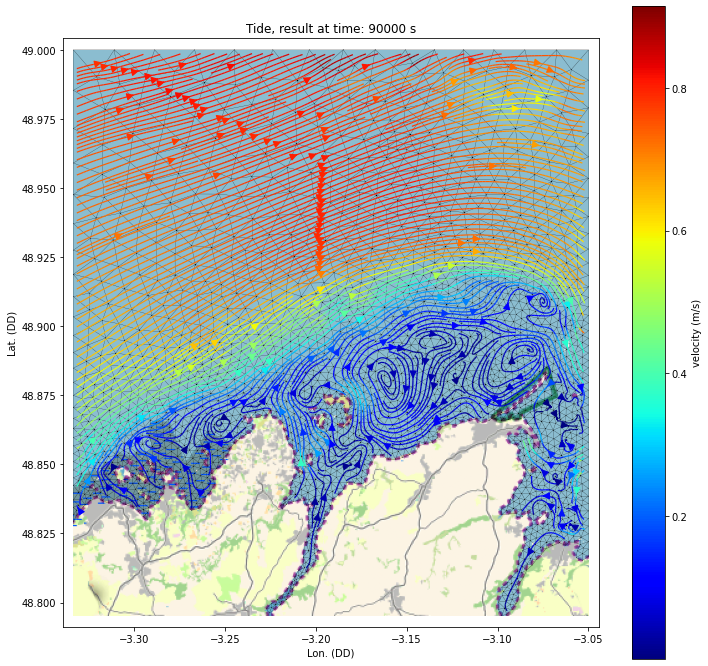

In [4]:
# Initialising matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

# Plotting mesh 
plot2d_triangle_mesh(ax, res.tri, color='k', linewidth=0.2)

# Background image
xlim = [np.min(res.tri.x), np.max(res.tri.x)]
ylim = [np.min(res.tri.y), np.max(res.tri.y)]
img_file = path.join(environ['HOMETEL'], 'notebooks', 'data', 'background_map.png')
plot2d_image(ax, image_file=img_file, 
             extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
             aspect=1.52, alpha=1.)

# Plot streamlines
plot2d_streamlines(fig, ax, res.tri, Ux, Uy, 
                   grid_resolution=[150, 150], 
                   data_name='velocity (m/s)', density=5, linewidth=1.2)

# Defining labels
ax.set_title('Tide, result at time: %d s'%res.times[0])
ax.set_xlabel('Lon. (DD)')
ax.set_ylabel('Lat. (DD)')

# Showing the plot
plt.show()

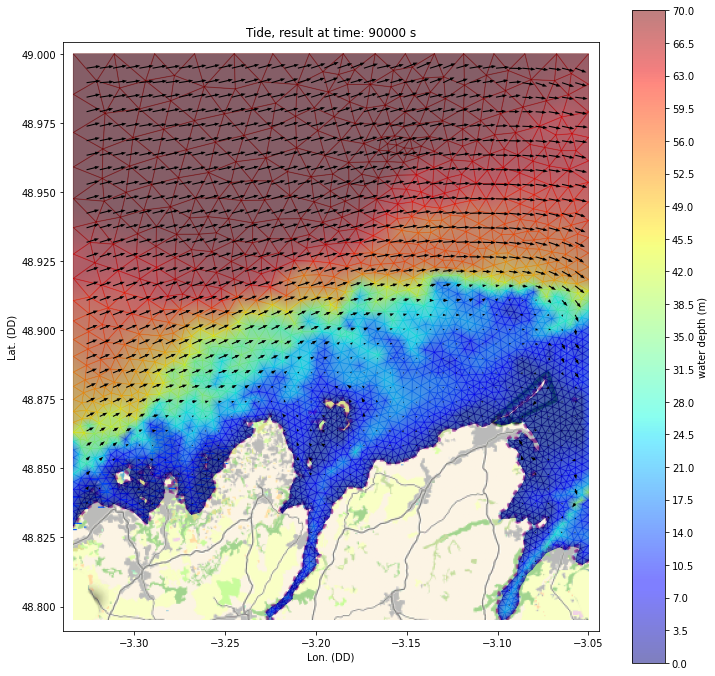

In [5]:
# Initialising matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

# Plotting mesh 
plot2d_triangle_mesh(ax, res.tri, color='k', linewidth=0.2)

# Background image
xlim = [np.min(res.tri.x), np.max(res.tri.x)]
ylim = [np.min(res.tri.y), np.max(res.tri.y)]
img_file = path.join(environ['HOMETEL'], 'notebooks', 'data', 'background_map.png')
plot2d_image(ax, image_file=img_file,
             extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
             aspect=1.52, alpha=1.)

# Plotting scalar map
plot2d_scalar_map(fig, ax, res.tri, H, data_name='water depth (m)', vmin=0, vmax=70, nv=21, alpha=0.5)

# Plotting vectors 
plot2d_vectors(fig, ax, res.tri, Ux, Uy, data_name='velocity',\
               normalize=False,
               scale=30,
               grid_resolution=[40, 40],
               grid_xlim=xlim, grid_ylim=ylim,
               color='k',
               width=0.002, headwidth=3., headlength=4.)

# Defining labels
ax.set_title('Tide, result at time: %d s'%res.times[0])
ax.set_xlabel('Lon. (DD)')
ax.set_ylabel('Lat. (DD)')

# Showing the plot
plt.show()

In [6]:
# Closing file
del res

## Automatically extract image from WMS flux with owslib

In this example, background image is extracted from Web Map Service server automatically with the "owslib" package. 

To install this package with conda, run one of the following:

    conda install -c conda-forge owslib
    conda install -c conda-forge/label/gcc7 owslib
    conda install -c conda-forge/label/cf201901 owslib 

See also: https://geopython.github.io/OWSLib/

In [7]:
from os import environ, path, system
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
try:
    import pyproj
    from owslib.wms import WebMapService
except ImportError:
    raise Exception("Warning: pyproj and owslib are mandatory for that example")
from data_manip.extraction.telemac_file import TelemacFile
from postel.plot2d import *

# File we are going to use
file_name = path.join(environ['HOMETEL'], 
                      'examples', 
                      'telemac2d', 
                      'tide',
                      'f2d_tide-jmj_type.slf')

# Initialising Telemac file reader
res = TelemacFile(file_name)

# Getting values
H = res.get_data_value('WATER DEPTH', 0)
Ux = res.get_data_value('VELOCITY U', 0)
Uy = res.get_data_value('VELOCITY V', 0)

# Coordoate projections
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
lamb1=pyproj.Proj("+init=EPSG:27561")

# Conversion from Lambert Nord to WGS84
res.tri.x, res.tri.y = pyproj.transform(lamb1, wgs84, res.tri.x, res.tri.y)

# Get frame limits
xlim = [np.min(res.tri.x), np.max(res.tri.x)]
ylim = [np.min(res.tri.y), np.max(res.tri.y)]

/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/d60881/opt2/python-3.7.13/arch/S10/gnu-8.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This function is deprec

### Get background image from WMServer

A valid WMS server adress is needed to extract the image.
In this example an Open Street Map server is used.

Several layers are available on this server and can be selected via the "layers" argument.

In [8]:
wms = WebMapService('http://ows.terrestris.de/osm/service')
print(wms.contents)

OrderedDict([('OSM-WMS', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774850>), ('OSM-WMS-no-labels', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774c90>), ('OSM-Overlay-WMS', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774e10>), ('TOPO-WMS', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774ed0>), ('TOPO-OSM-WMS', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774d90>), ('SRTM30-Hillshade', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774950>), ('SRTM30-Colored', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774bd0>), ('SRTM30-Colored-Hillshade', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774910>), ('SRTM30-Contour', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774b50>), ('Dark', <owslib.map.wms111.ContentMetadata object at 0x7f98ba774990>)])


In [9]:
top_right_point = [ylim[1], xlim[1]]
bottom_left_point = [ylim[0], xlim[0]]

img = wms.getmap(layers=['SRTM30-Hillshade'],
                 srs='EPSG:4326',
                 bbox=(bottom_left_point[1], bottom_left_point[0], top_right_point[1], top_right_point[0]),
                 size=(2000, 2000),
                 format='image/png')

Once the image is defined, it can be saved into a file as follows:

In [10]:
out = open('background_image.png', 'wb')
out.write(img.read())
out.close()

The image can then be used in plots:

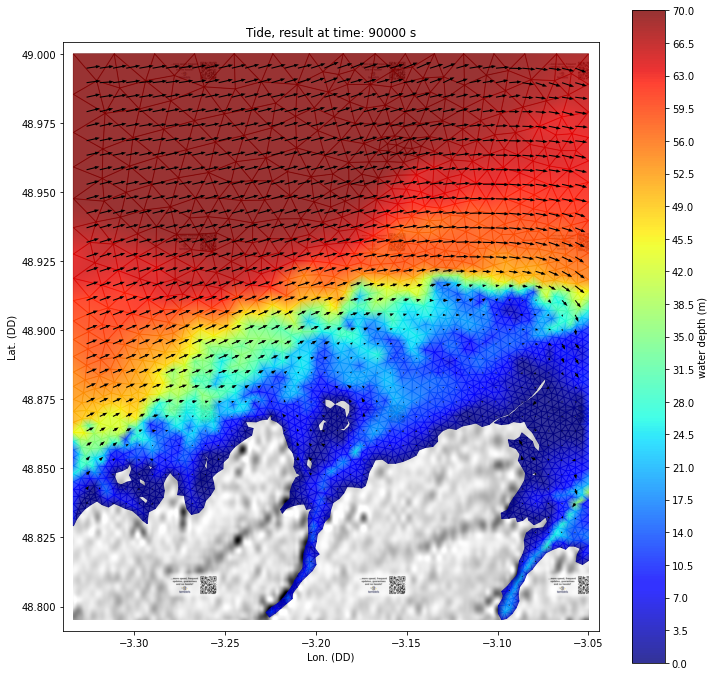

In [11]:
# Initialising matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

# Plotting mesh 
plot2d_triangle_mesh(ax, res.tri, color='k', linewidth=0.2)

# Background image
xlim = [np.min(res.tri.x), np.max(res.tri.x)]
ylim = [np.min(res.tri.y), np.max(res.tri.y)]
plot2d_image(ax, image_file='background_image.png',
             extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
             aspect=1.52, alpha=1.)

# Plotting scalar map only on wet zones
plot2d_scalar_map(fig, ax, res.tri, H, data_name='water depth (m)', vmin=0, vmax=70, nv=21, alpha=.8)

# Plotting vectors 
plot2d_vectors(fig, ax, res.tri, Ux, Uy, data_name='velocity',\
               normalize=False,
               scale=30,
               grid_resolution=[40, 40],
               grid_xlim=xlim, grid_ylim=ylim,
               color='k',
               width=0.002, headwidth=3., headlength=4.)

# Defining labels
ax.set_title('Tide, result at time: %d s'%res.times[0])
ax.set_xlabel('Lon. (DD)')
ax.set_ylabel('Lat. (DD)')

# Showing the plot
plt.show()

In [12]:
res.close()